# Written By David Benisty

In [2]:
import numpy as np
from numpy import pi, log, sqrt, power

# load Cosmic Chronometers dataset
ccData = np.genfromtxt("CC.txt")
ccData = ccData[np.argsort(ccData[:,0])]  #orgenize the array with respect to the z part (ccData[:,1])
# load Pantheon dataset
panthData = np.genfromtxt("lcparam_full_long_zhel.txt")
panthData = panthData[np.argsort(panthData[:,1])] #orgenize the array with respect to the z part (ccData[:,1])

In [2]:
from scipy.integrate import odeint
#H functions
c = 299792.458

def E(theta,z):
    H0, Om, M = theta
    return np.sqrt(Om*(1+z)**3 + (1-Om))

def dchidz(x,z, H0, Om, M):
    return 1/E([H0, Om, M],z)

def chiInt(theta,z):
    H0, Om, M = theta
    z = np.hstack((np.array((0)), z))
    arr = odeint(dchidz,0,z,args=(H0, Om, M,))
    return np.delete(arr ,0)

chiInt([67,0.31,-19],[1,2,3,4])

array([0.76690281, 1.19925799, 1.46968511, 1.65692792])

In [3]:
def Harr(theta,z):
    H0, Om, M = theta
    arr = []
    
    for i in range(len(z)):
        arr.append(H0*E(theta,z[i]))
    arr = np.array(arr)
    arr.shape
    return arr

Harr([67,0.31,-19],[1,2,3,4])

array([119.29010856, 201.66888704, 303.57728835, 420.76853495])

In [4]:
def DL(theta,z):
    H0, Om, M = theta
    chi = chiInt(theta,z)
    return c*chi/H0

def mu(theta,z):
    H0, Om, M = theta

    dL = DL(theta,z)    
    mu = []
    
    for i in range(len(z)):
        mu.append(5*np.log10(dL[i]*(1+z[i])) + 25 + M)
    mu = np.array(mu)
    mu.shape
    return mu

mu([67,0.31,-19],[1,2,3])

array([25.18258114, 27.03389888, 28.10015093])

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


Text(0,0.5,'$\\mu$')

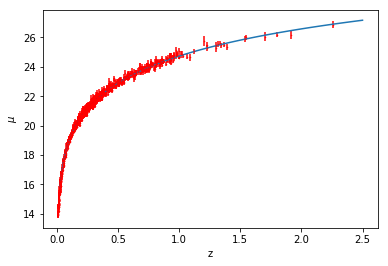

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

zz = np.linspace(0,2.5,100)
plt.plot(zz,mu([74,0.31,-19.2334],zz))
plt.errorbar(panthData[:,1], panthData[:,4], panthData[:,5], fmt='r.', markersize=1,label = 'Pantheon')

plt.xlabel('z')
plt.ylabel('$\mu$')

In [6]:
#general Likelihood function for uncorrelated dataset
def lnlike(theta,fun,x,y,dy):
    chi2 = 0
    arr = fun(theta,x)
    for j in range(len(x)):
        chi2 += ((arr[j] - y[j])/dy[j])**2
    return chi2

print(lnlike([74,0.31,-19.2334],mu,panthData[:,1], panthData[:,4], panthData[:,5]),"for Pantheon")
print(lnlike([69,0.31,-19.2334],Harr,ccData[:,0], ccData[:,1], ccData[:,2]),"for Cosmic Chronometers")

(1044.7051926034337, 'for Pantheon')
(14.611496165415147, 'for Cosmic Chronometers')


In [7]:
# the likelihoods for the Polychord
def lnlikeCC(theta):
    H0, Om, M = theta
    chi2 = lnlike(theta,Harr,ccData[:,0], ccData[:,1], ccData[:,2])
    return -chi2, [chi2, chi2/(len(ccData[:,0])-3),1-Om]

def lnlikeIa(theta):
    H0, Om, M = theta
    chi2 = lnlike(theta,mu,panthData[:,1], panthData[:,4], panthData[:,5])
    return -chi2, [chi2, chi2/(len(panthData[:,1])-3),1-Om]

def lnlikeTot(theta):
    H0, Om, M = theta
    chi2 = lnlike(theta,Harr,ccData[:,0], ccData[:,1], ccData[:,2])
    chi2 += lnlike(theta,mu,panthData[:,1], panthData[:,4], panthData[:,5]) 
    return -chi2, [chi2, chi2/(len(ccData[:,0])+len(panthData[:,1])-3),1-Om]

In [8]:
import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior, GaussianPrior

def unipriorLCDM(hypercube):
    prior = []
    prior.append(UniformPrior(50,100)(hypercube[0]))
    prior.append(UniformPrior(0.,1.)(hypercube[1]))
    prior.append(GaussianPrior(-19.2334,0.0404)(hypercube[2]))
    return prior

runs = 40

def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [9]:
settingsCC = PolyChordSettings(3,3)
settingsCC.file_root = 'CC'
settingsCC.nlive = runs
settingsCC.do_clustering = True
settingsCC.read_resume = False

settingsIa = PolyChordSettings(3,3)
settingsIa.file_root = 'Ia'
settingsIa.nlive = runs
settingsIa.do_clustering = True
settingsIa.read_resume = False

settingsCCIa = PolyChordSettings(3,3)
settingsCCIa.file_root = 'CCIa'
settingsCCIa.nlive = runs
settingsCCIa.do_clustering = True
settingsCCIa.read_resume = False

In [10]:
outputCC = pypolychord.run_polychord(lnlikeCC, 3, 3, settingsCC, unipriorLCDM, dumper)

('Last dead point:', array([ 62.83242652,   0.73611514, -19.21665954,  78.08637776,
         3.00332222,   0.26388486, -88.6350579 , -78.08637776]))
('Last dead point:', array([ 67.89101329,   0.20931347, -19.22445075,  30.59188922,
         1.17661112,   0.79068653, -67.58782619, -30.59188922]))
('Last dead point:', array([ 60.25793022,   0.45013956, -19.24507539,  21.25433488,
         0.81747442,   0.54986044, -26.91280587, -21.25433488]))
('Last dead point:', array([ 71.70905462,   0.24053622, -19.26406263,  16.79378278,
         0.64591472,   0.75946378, -20.23727216, -16.79378278]))
('Last dead point:', array([ 65.32583683,   0.36963271, -19.19378046,  15.33118251,
         0.58966087,   0.63036729, -16.62202729, -15.33118251]))
('Last dead point:', array([ 69.76358957,   0.28729963, -19.31611185,  14.84719693,
         0.57104604,   0.71270037, -16.11552959, -14.84719693]))
('Last dead point:', array([ 69.19558008,   0.30218554, -19.24622236,  14.63135371,
         0.56274437,  

/home/benidav/.local/lib/python2.7/site-packages/pypolychord/output.py:191: FutureWarning: read_table is deprecated, use read_csv instead.
  names= initial_col_names)


In [11]:
outputIa = pypolychord.run_polychord(lnlikeIa, 3, 3, settingsIa, unipriorLCDM, dumper)

('Last dead point:', array([ 7.71584119e+01,  6.57863129e-01, -1.92327407e+01,  4.58775492e+03,
        4.39019609e+00,  3.42136871e-01, -1.00000000e+30, -4.58775492e+03]))
('Last dead point:', array([ 7.76885734e+01,  1.93922154e-01, -1.92900999e+01,  1.94547416e+03,
        1.86169776e+00,  8.06077846e-01, -2.02142382e+03, -1.94547416e+03]))
('Last dead point:', array([ 6.83763017e+01,  4.74482307e-01, -1.92742631e+01,  1.39838819e+03,
        1.33817052e+00,  5.25517693e-01, -1.94547416e+03, -1.39838819e+03]))
('Last dead point:', array([ 7.11223038e+01,  4.11879832e-01, -1.93007460e+01,  1.17852848e+03,
        1.12777845e+00,  5.88120168e-01, -1.27392974e+03, -1.17852848e+03]))
('Last dead point:', array([ 7.47466279e+01,  2.77790029e-01, -1.92402706e+01,  1.07109008e+03,
        1.02496658e+00,  7.22209971e-01, -1.15668354e+03, -1.07109008e+03]))
('Last dead point:', array([ 7.29450053e+01,  3.08708016e-01, -1.92431594e+01,  1.04797914e+03,
        1.00285085e+00,  6.91291984e-01

In [12]:
outputTot = pypolychord.run_polychord(lnlikeTot, 3, 3, settingsCCIa, unipriorLCDM, dumper)

('Last dead point:', array([ 8.27048920e+01,  2.77255398e-01, -1.92990366e+01,  6.45800672e+03,
        6.01304164e+00,  7.22744602e-01, -1.00000000e+30, -6.45800672e+03]))
('Last dead point:', array([ 7.24152738e+01,  6.56504215e-01, -1.92689153e+01,  2.66433035e+03,
        2.48075452e+00,  3.43495785e-01, -3.10424727e+03, -2.66433035e+03]))
('Last dead point:', array([ 7.44440458e+01,  1.37195888e-01, -1.92080733e+01,  1.64899220e+03,
        1.53537449e+00,  8.62804112e-01, -8.25827033e+03, -1.64899220e+03]))
('Last dead point:', array([ 6.92154120e+01,  4.76291122e-01, -1.92820779e+01,  1.28510509e+03,
        1.19655967e+00,  5.23708878e-01, -1.38578462e+03, -1.28510509e+03]))
('Last dead point:', array([ 7.27384351e+01,  3.22575445e-01, -1.92239978e+01,  1.12707067e+03,
        1.04941403e+00,  6.77424555e-01, -1.23615205e+03, -1.12707067e+03]))
('Last dead point:', array([ 7.48959668e+01,  3.05940296e-01, -1.92171489e+01,  1.08594317e+03,
        1.01112027e+00,  6.94059704e-01

In [13]:
paramnamesLCDM = [('h0','H_0 (km/sec/Mpc)'),('Om', '\Omega_m'),('M','M'),('chi','chi'),('L',r'L'),('ol', r'\Omega_\Lambda')]
outputCC.make_paramnames_files(paramnamesLCDM);posteriorCC = outputCC.posterior;
outputIa.make_paramnames_files(paramnamesLCDM);posteriorIa = outputIa.posterior;
outputTot.make_paramnames_files(paramnamesLCDM);posteriorTot = outputTot.posterior;

chains/CC.txt
Removed no burn in
chains/Ia.txt
Removed no burn in
chains/CCIa.txt


Removed no burn in


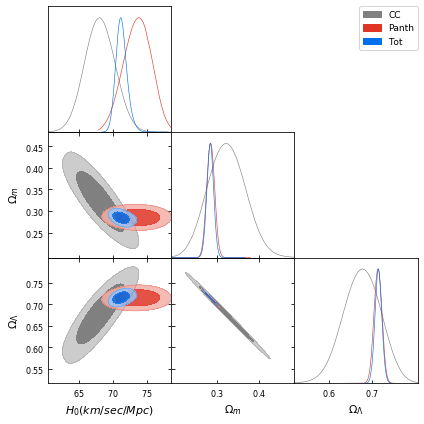

In [19]:
from getdist import plots, MCSamples
import getdist


g = getdist.plots.getSubplotPlotter()
g.triangle_plot([posteriorCC,posteriorIa,posteriorTot], ('h0','Om','ol') ,filled=True, legend_labels=[r'CC',r'Panth',r'Tot'])
g.export("CCPanTot.eps")

In [20]:
outputCC

Global evidence:
log(Z)    -19.427277 +/-  0.311643

Local evidences:
log(Z_1)    -21.082480 +/-  0.322164
log(Z_2)    -22.446459 +/-  0.341635
log(Z_3)    -21.322738 +/-  0.326995
log(Z_4)    -21.979045 +/-  0.339787
log(Z_5)    -22.120271 +/-  0.353091
log(Z_6)    -20.203265 +/-  0.314916

Run-time information:
<nlike>       [0.0]
ncluster          6
ndead           540
nequals          98
nlike         50282
nlive             0
nposterior      540

Parameter estimates:
h0   H_0 (km/sec/Mpc)     6.809E+01 +\- 2.123E+00
Om   \Omega_m             3.238E-01 +\- 4.152E-02
M    M                   -1.923E+01 +\- 4.162E-02
chi  chi                  1.549E+01 +\- 8.651E-01
L    L                    5.958E-01 +\- 3.327E-02
ol   \Omega_\Lambda       6.762E-01 +\- 4.152E-02

In [21]:
outputIa

Global evidence:
log(Z)    -1044.267103 +/-  0.430693

Local evidences:
log(Z_1)     -1054.350772 +/-  0.842529
log(Z_2)     -1047.154323 +/-  0.590964
log(Z_3)     -1047.956940 +/-  0.514389
log(Z_4)     -1046.885900 +/-  0.494186
log(Z_5)     -1045.127967 +/-  0.475860
log(Z_6)     -1047.171980 +/-  0.587568
log(Z_7)     -1048.073210 +/-  0.595787
log(Z_8)     -1045.792904 +/-  0.564738
log(Z_9)     -1048.265758 +/-  0.597195
log(Z_10)    -1048.169974 +/-  0.595925
log(Z_11)    -1047.316104 +/-  0.500187

Run-time information:
<nlike>       [0.0]
ncluster         11
ndead           720
nequals          76
nlike         62591
nlive             0
nposterior      720

Parameter estimates:
h0   H_0 (km/sec/Mpc)     7.392E+01 +\- 1.700E+00
Om   \Omega_m             2.857E-01 +\- 7.721E-03
M    M                   -1.924E+01 +\- 4.990E-02
chi  chi                  1.036E+03 +\- 9.371E-01
L    L                    9.918E-01 +\- 8.968E-04
ol   \Omega_\Lambda       7.143E-01 +\- 7.721E-03

In [22]:
outputTot

Global evidence:
log(Z)    -1062.575438 +/-  0.525441

Local evidences:
log(Z_1)    -1072.489254 +/-  0.801568
log(Z_2)    -1068.526455 +/-  0.605474
log(Z_3)    -1067.666151 +/-  0.665798
log(Z_4)    -1065.092382 +/-  0.532782
log(Z_5)    -1065.129245 +/-  0.611836
log(Z_6)    -1062.768912 +/-  0.533931

Run-time information:
<nlike>       [0.0]
ncluster          6
ndead           793
nequals          32
nlike         58477
nlive             0
nposterior      793

Parameter estimates:
h0   H_0 (km/sec/Mpc)     7.138E+01 +\- 7.952E-01
Om   \Omega_m             2.840E-01 +\- 8.358E-03
M    M                   -1.931E+01 +\- 2.329E-02
chi  chi                  1.053E+03 +\- 1.250E+00
L    L                    9.800E-01 +\- 1.164E-03
ol   \Omega_\Lambda       7.160E-01 +\- 8.358E-03

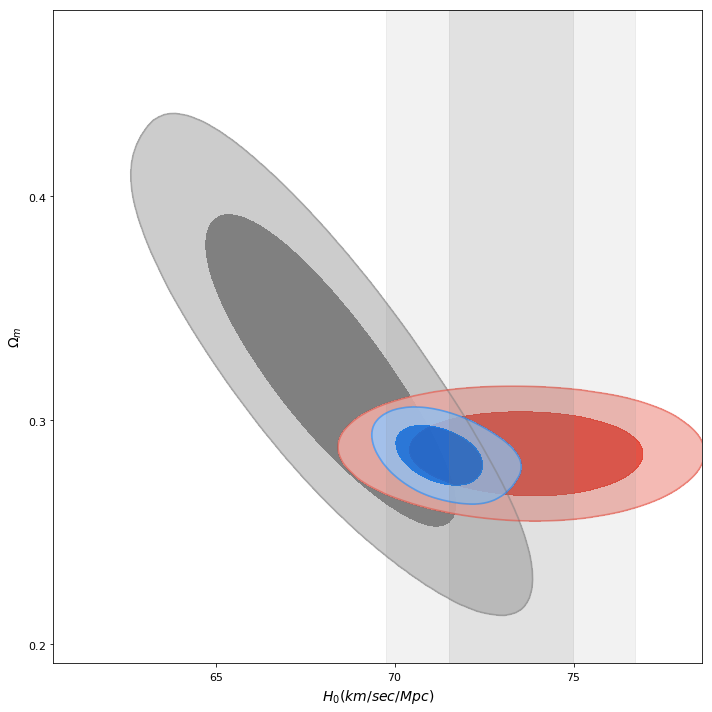

In [18]:
g = plots.get_single_plotter(width_inch=10, ratio=1)
g.plot_2d([posteriorCC,posteriorIa,posteriorTot], 'h0', 'Om', filled=True)
g.add_x_bands(73.24,1.74)